# 3.1 Estadistica Descriptiva

**AUTOR: Fabrizio Ramirez Cutimbo**

**OBJETIVOS:**

- Aplicar técnicas de estadística descriptiva al conjunto de datos completo, compilado y limpio para  caracterizar el sector empresarial ecuatoriano.
- Descripción general del dataset con enfoque en tamaño de las empresas, ubicación geográfica, actividad económica y tipo de empresa.

In [1]:
import pandas as pd
import numpy as np
#Graficos
import matplotlib.pyplot as plt
import seaborn as sns


### Cargar Dataset

In [2]:
# Establecere formato de 2 decimales
pd.set_option('display.float_format', '{:.2f}'.format)
# pd.set_option('display.max_colwidth', None) 

# Se utiliza el dataset completo
pd_companias = pd.read_csv('Datasets Procesados/directorio_empresas_final_ciiu_completo.csv', dtype={'EXPEDIENTE': 'object', 'RUC': 'object'})
pd_companias.sample(1)

,EXPEDIENTE,RUC,SITUACION_LEGAL,FECHA_CONSTITUCION,TIPO,PAIS,REGION,PROVINCIA,CANTON,CIUDAD,...,SEGMENTO,IF_PRUEBA_ACIDA,IF_ENDEUDAMIENTO_ACTIVO,IF_APALANCAMIENTO,IF_ROTACION_VENTAS,IF_MARGEN_BRUTO,IF_MARGEN_OPERCIONAL,IF_MARGEN_NETO,IF_ROE,IF_ROA
5239,39150,0790090667001,ACTIVA,21/05/1992,ANÓNIMA,ECUADOR,COSTA,EL ORO,MACHALA,MACHALA,...,MICRO,2.52,0.23,1.30,3.86,1.00,0.01,0.00,0.00,0.00


In [3]:
pd_companias.columns

Index(['EXPEDIENTE', 'RUC', 'SITUACION_LEGAL', 'FECHA_CONSTITUCION', 'TIPO',
       'PAIS', 'REGION', 'PROVINCIA', 'CANTON', 'CIUDAD', 'CIIU_NIVEL_1',
       'CIIU_NIVEL_1_DESC', 'CIIU_NIVEL_3', 'CIIU_NIVEL_3_DESC',
       'CIIU_NIVEL_4', 'CIIU_NIVEL_4_DESC', 'CIIU_NIVEL_6',
       'CIIU_NIVEL_6_DESC', 'ACTIVO_2022', 'ACTIVO_CORRIENTE_2022',
       'INVENTARIOS_2022', 'ACTIVOS_NO_CORRIENTES_2022', 'PASIVO_2022',
       'PASIVO_CORRIENTE_2022', 'PASIVO_NO_CORRIENTE_2022',
       'PATRIMONIO_NETO_2022', 'INGRESOS_ACTIVIDADES_ORDINARIAS_2022',
       'GANANCIA_BRUTA_2022', 'OTROS_INGRESOS_2022',
       'COSTO_VENTAS_PRODUCCION_2022', 'GASTOS_2022',
       'UTILIDAD_OPERATIVA_2022', 'GANACIA_PERDIDA_ANTES_IR_2022',
       'IMPUESTO_RENTA_2022', 'UTILIDAD_NETA_2022', 'ACTIVO_2023',
       'ACTIVO_CORRIENTE_2023', 'INVENTARIOS_2023',
       'ACTIVOS_NO_CORRIENTES_2023', 'PASIVO_2023', 'PASIVO_CORRIENTE_2023',
       'PASIVO_NO_CORRIENTE_2023', 'PATRIMONIO_NETO_2023',
       'INGRESOS_ACTIVID

### Funciones generales

In [4]:
def agrupar_y_reducir_a_top_categories(dataset, group_col, value_col='Count', top_n=4):
    """
    Agrupa un DataFrame por la columna especificada, cuenta los registros,
    reduce a los Top N principales y agrupa el resto en "Otras".

    Args:
        dataset (pd.DataFrame): DataFrame de entrada.
        group_col (str): Columna por la que se agrupa.
        value_col (str): Nombre de la nueva columna de conteo (por defecto 'Count').
        top_n (int): Número de principales categorías a mantener (por defecto 4).

    Returns:
        pd.DataFrame: DataFrame reducido con las principales categorías y "Otras".
    """
    grouped = dataset.groupby(group_col).size().reset_index(name=value_col)
    grouped = grouped.sort_values(by=value_col, ascending=False)

    if len(grouped) > top_n:
        top_categories = grouped.head(top_n)
        others_count = grouped.iloc[top_n:].sum(numeric_only=True)
        others_row = pd.DataFrame([[f'Otras', others_count[value_col]]], columns=[group_col, value_col])
        grouped = pd.concat([top_categories, others_row], ignore_index=True)

    return grouped

def presentar_grafico_barras(dataset, x_col, y_col, show_percentage=False, color='steelblue', figsize=(8, 6), title=''):
    """
    Crea un gráfico de barras horizontal basado en las columnas especificadas.

    Args:
        dataset (pd.DataFrame): DataFrame con los datos a graficar.
        x_col (str): Columna para el eje X.
        y_col (str): Columna para el eje Y.
        show_percentage (bool): Si se debe calcular y mostrar el porcentaje (por defecto False).
        color (str): Color de las barras (por defecto 'steelblue').
        figsize (tuple): Tamaño del gráfico como (ancho, alto) (por defecto (8, 6)).
        title (str): Título del gráfico (por defecto vacío).
    """
    # Calcular el porcentaje si es necesario
    if show_percentage:
        total = dataset[x_col].sum()
        dataset['Porcentaje'] = (dataset[x_col] / total) * 100

     # Truncar los valores de la columna 'y_col' si tienen más de 20 caracteres
    dataset[y_col] = dataset[y_col].apply(lambda x: x[:60] + '...' if len(x) > 60 else x)

    def format_large_number(value):
        if value >= 1_000_000:
            formatted = f"{value / 1_000_000:,.1f}M"
        # elif value >= 1_000:
        #     formatted = f"{value / 1_000:,.1f}K"
        else:
            formatted = f"{value:.0f}"
        return formatted.replace(',', "'")

    plt.figure(figsize=figsize)
    sns.barplot(x=x_col, y=y_col, data=dataset, color=color)

    # Mostrar el número y porcentaje al final de cada barra
    for p, value in zip(plt.gca().patches, dataset[x_col]):
        width = p.get_width()
        formatted_value = format_large_number(value)
        if show_percentage:
            perc = (value / total) * 100
            label = f'{formatted_value} ({perc:.1f}%)'
        else:
            label = formatted_value
        plt.text(width + 0.5, p.get_y() + p.get_height() / 2,
                 label, va='center', fontsize=10, color='black')

    # Agregar título al gráfico
    if title:
        plt.title(title, fontsize=14)

    # Eliminar bordes
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Eliminar la escala y ticks del eje X
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel(y_col, fontsize=10)
    plt.tight_layout()
    plt.show()

def sumar_y_reducir_a_top_categories(dataset, group_col, value_col, top_n=5):
    """
    Agrupa un DataFrame por una columna, suma los valores de otra columna,
    reduce a las principales categorías y agrupa las demás en una categoría llamada 'Otras'.

    Args:
        dataset (pd.DataFrame): El DataFrame de entrada.
        group_col (str): La columna por la que se agruparán los datos.
        value_col (str): La columna cuyos valores se sumarán.
        top_n (int): Número de categorías principales a conservar (por defecto 5).

    Returns:
        pd.DataFrame: Un nuevo DataFrame con las principales categorías y una categoría 'Otras'.
    """
    # Agrupar por la columna de agrupación y sumar los valores
    grouped = dataset.groupby(group_col)[value_col].sum().reset_index()
    
    # Ordenar de mayor a menor según los valores sumados
    grouped = grouped.sort_values(by=value_col, ascending=False)
    
    # Separar las principales categorías y las demás
    if len(grouped) > top_n:
        top_categories = grouped.head(top_n)
        other_sum = grouped.iloc[top_n:][value_col].sum()
        other_row = pd.DataFrame([{group_col: 'Otras', value_col: other_sum}])
        grouped = pd.concat([top_categories, other_row], ignore_index=True)
    
    return grouped

### Caracteristicas del Registro Estadístico

Numero de compañías analizadas (año corte 2023): **88673**

In [5]:
print(f'Número de Compañias: {pd_companias.shape[0]}')

Número de Compañias: 88673


Evolución en la constitución de compañías en los últimos 6 años

Número de Compañias con fecha erronea: 0

C:\Users\fabrizio\AppData\Local\Temp\ipykernel_16968\4166959702.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd_companias['FECHA_CONSTITUCION'] = pd.to_datetime(pd_companias['FECHA_CONSTITUCION'], errors='coerce')



    Año  Compañías Constituidas  Nro Total Compañías
0  2023                    6636                88673
1  2022                   10458                82037
2  2021                    8825                71579
3  2020                    5713                62754
4  2019                    5125                57041
5  2018                    4276                51916


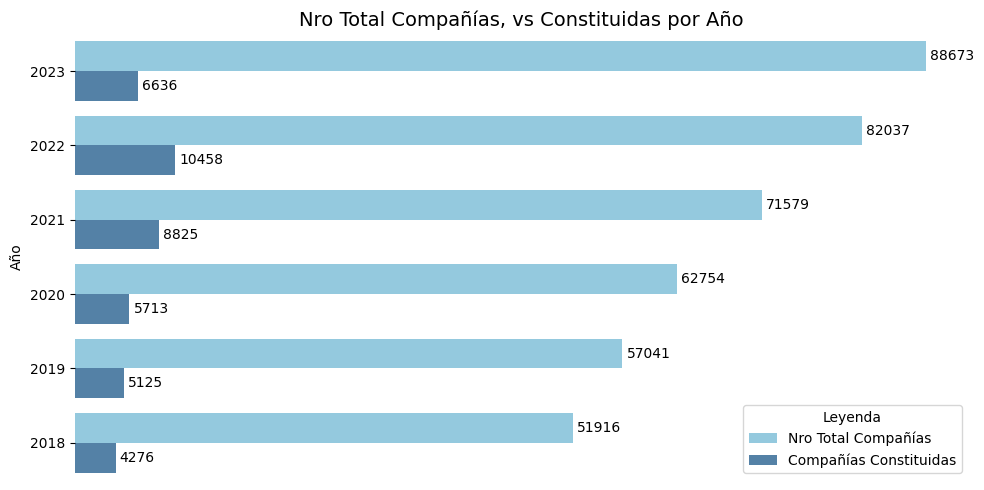

In [6]:
#Transformamos a Date Time la coumna FECHA_CONSTITUCION
pd_companias['FECHA_CONSTITUCION'] = pd.to_datetime(pd_companias['FECHA_CONSTITUCION'], errors='coerce')

# Validamos que no existan errores de transformación 
print(f'Número de Compañias con fecha erronea: {pd_companias[pd_companias['FECHA_CONSTITUCION'].isna()].shape[0]}')


conteo_2023 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2023-12-31'].shape[0]
conteo_2022 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2022-12-31'].shape[0]
conteo_2021 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2021-12-31'].shape[0]
conteo_2020 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2020-12-31'].shape[0]
conteo_2019 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2019-12-31'].shape[0]
conteo_2018 = pd_companias[pd_companias['FECHA_CONSTITUCION'] <= '2018-12-31'].shape[0]

empresas_const_2023 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2023].shape[0]
empresas_const_2022 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2022].shape[0]
empresas_const_2021 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2021].shape[0]
empresas_const_2020 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2020].shape[0]
empresas_const_2019 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2019].shape[0]
empresas_const_2018 = pd_companias[pd_companias['FECHA_CONSTITUCION'].dt.year == 2018].shape[0]


# Crear un nuevo DataFrame con los datos sumarizados
recuento_empresas = pd.DataFrame({
    'Año': ['2023', '2022', '2021', '2020', '2019', '2018'],
    'Compañías Constituidas': [empresas_const_2023, empresas_const_2022, empresas_const_2021, empresas_const_2020, empresas_const_2019, empresas_const_2018],
    'Nro Total Compañías': [conteo_2023, conteo_2022, conteo_2021, conteo_2020, conteo_2019, conteo_2018]
})

print(recuento_empresas)

# transforma la tabla para visualizarla en un grafico
recuento_empresas_transpuesta = recuento_empresas.melt(id_vars="Año", 
                                                  value_vars=["Nro Total Compañías", "Compañías Constituidas"],
                                                  var_name="Tipo", 
                                                  value_name="Cantidad")
# print(recuento_empresas_transpuesta)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 5))
sns.barplot( data=recuento_empresas_transpuesta,
    x="Cantidad", y="Año", hue="Tipo", palette={"Nro Total Compañías": "skyblue", "Compañías Constituidas": "steelblue"})

# Añadir etiquetas y título
plt.title("Nro Total Compañías, vs Constituidas por Año", fontsize=14)
plt.xlabel("")
plt.ylabel("Año")
plt.legend(title="Leyenda")
plt.gca().xaxis.set_visible(False)


# plt.gca().spines['top'].set_visible(False)
# Quitar los bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Añadir etiquetas en las barras
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%d", padding=3)

plt.tight_layout()
plt.show()

Variación en la constitución de garantías:
+ Se puede ver que en el año 2023 se constituyeron 36% menos empresas que el año 2022, siendo este el único en el que se registra un decremiento desde los últimso 6 años.

In [7]:
recuento_empresas = recuento_empresas.sort_values(by='Año', ascending=True)
# Calcular la Variación en la constitución de empresas respecto al año anterior
# Se utiliza la función PCT_CHANGE de pandas que hace este análisis
recuento_empresas['Variación en Constitución (%)'] = recuento_empresas['Compañías Constituidas'].pct_change() * 100
# Mostrar el DataFrame con la variación
recuento_empresas

,Año,Compañías Constituidas,Nro Total Compañías,Variación en Constitución (%)
5,2018,4276,51916,NaN
4,2019,5125,57041,19.86
3,2020,5713,62754,11.47
2,2021,8825,71579,54.47
1,2022,10458,82037,18.50
0,2023,6636,88673,-36.55


### Revisión por **Segmento**

Distribución de compañías en Ecuador por **Segmento** y por **Ingresos**

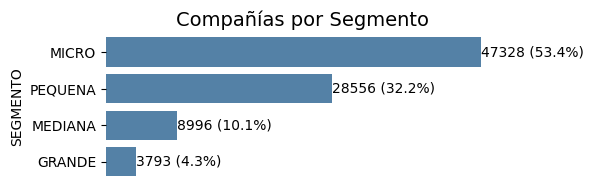

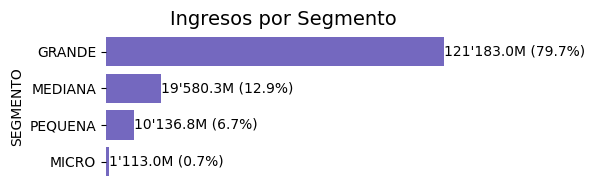

In [8]:
top_segmentos = agrupar_y_reducir_a_top_categories(pd_companias, group_col='SEGMENTO', value_col='Num_Compañías', top_n=4)
presentar_grafico_barras(top_segmentos, x_col='Num_Compañías', y_col='SEGMENTO', show_percentage=True, color='steelblue', figsize=(6, 2),
                         title='Compañías por Segmento')

# Reducir a top 4 categorías por suma de ingresos
top_ingresos_segmentos = sumar_y_reducir_a_top_categories(pd_companias, group_col='SEGMENTO', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=4
)
# print(top_ingresos_segmentos)
presentar_grafico_barras(top_ingresos_segmentos, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='SEGMENTO', show_percentage=True, color='slateblue', figsize=(6, 2),
                         title='Ingresos por Segmento')

### Revisión por **Tipo de Empresa**

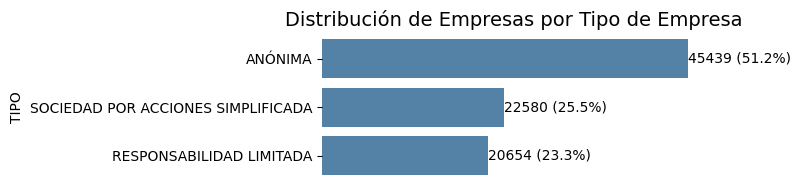

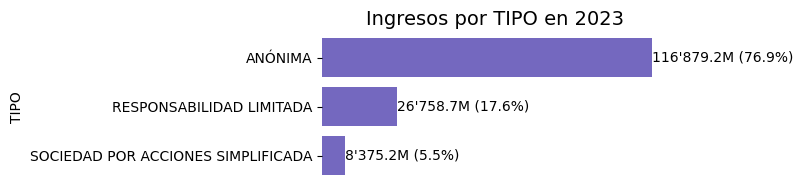

In [9]:
top_tipo_empresa = agrupar_y_reducir_a_top_categories(pd_companias, group_col='TIPO', value_col='Num_Compañías', top_n=4)
presentar_grafico_barras(top_tipo_empresa, x_col='Num_Compañías', y_col='TIPO', show_percentage=True, color='steelblue', figsize=(8, 2),
                         title='Distribución de Empresas por Tipo de Empresa')

# Reducir a top 4 categorías por suma de ingresos
top_ingresos_tipo_empresa = sumar_y_reducir_a_top_categories(pd_companias, group_col='TIPO', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=4
)
# print(top_ingresos_segmentos)
presentar_grafico_barras(top_ingresos_tipo_empresa, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='TIPO', show_percentage=True, color='slateblue', figsize=(8, 2),
                         title='Ingresos por TIPO en 2023')

+ Revisión Constitución de compañías desde 2010 por tipo.
Se observa crecimiento exponencial en SAS Sociedades por acciones simplificadas

<Figure size 640x480 with 0 Axes>

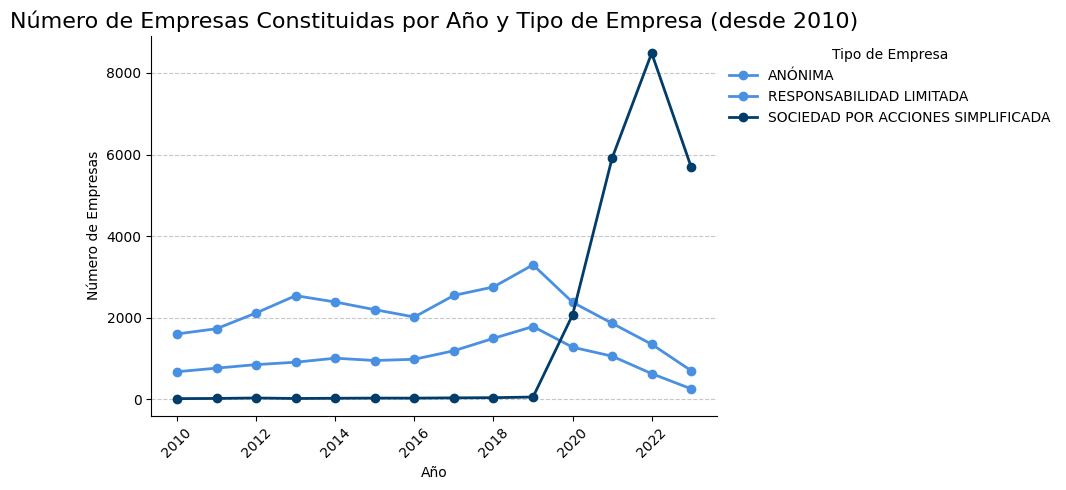

In [10]:
# Extraemos el año de la fecha de constitución
pd_companias['AÑO_CONSTITUCION'] = pd_companias['FECHA_CONSTITUCION'].dt.year

# Filtramos desde 2010
df_filtered_year = pd_companias[pd_companias['AÑO_CONSTITUCION'] >= 2010]

# Agrupamos por año y tipo de empresa y contamos las empresas
companies_per_year_tipo = df_filtered_year.groupby(['AÑO_CONSTITUCION', 'TIPO']).size().unstack(fill_value=0)

# Configuración del gráfico
plt.figure()
ax = companies_per_year_tipo.plot(kind='line', marker='o', figsize=(10, 5), linewidth=2)

# Estilo de líneas y colores
colors = ['#4A90E2', '#4A90E2', '#003D6B']  
for line, color in zip(ax.lines, colors):
    line.set_color(color)

# Título y etiquetas
plt.title('Número de Empresas Constituidas por Año y Tipo de Empresa (desde 2010)', fontsize=16)
plt.xlabel('Año')
plt.ylabel('Número de Empresas')

# Personalización de los ejes
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Añadir rejilla
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Leyenda
plt.legend(title='Tipo de Empresa', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Revisión por **Ubicación Geográfica**

Número de empresas por **Provincia**

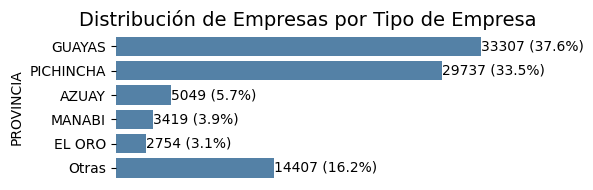

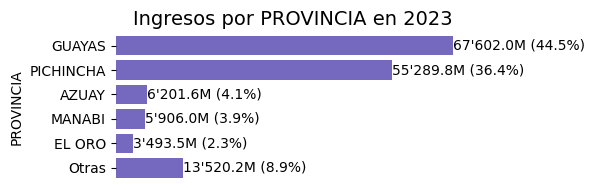

In [11]:
top_provincia = agrupar_y_reducir_a_top_categories(pd_companias, group_col='PROVINCIA', value_col='Num_Compañías', top_n=5)
presentar_grafico_barras(top_provincia, x_col='Num_Compañías', y_col='PROVINCIA', show_percentage=True, color='steelblue', figsize=(6, 2),
                         title='Distribución de Empresas por Tipo de Empresa')

# Reducir a top 4 categorías por suma de ingresos
top_ingresos_provincia = sumar_y_reducir_a_top_categories(pd_companias, group_col='PROVINCIA', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

# print(top_ingresos_segmentos)
presentar_grafico_barras(top_ingresos_provincia, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='PROVINCIA', show_percentage=True, color='slateblue', figsize=(6, 2),
                         title='Ingresos por PROVINCIA en 2023')

Número de empresas por CIIU 1 por **Provincia**

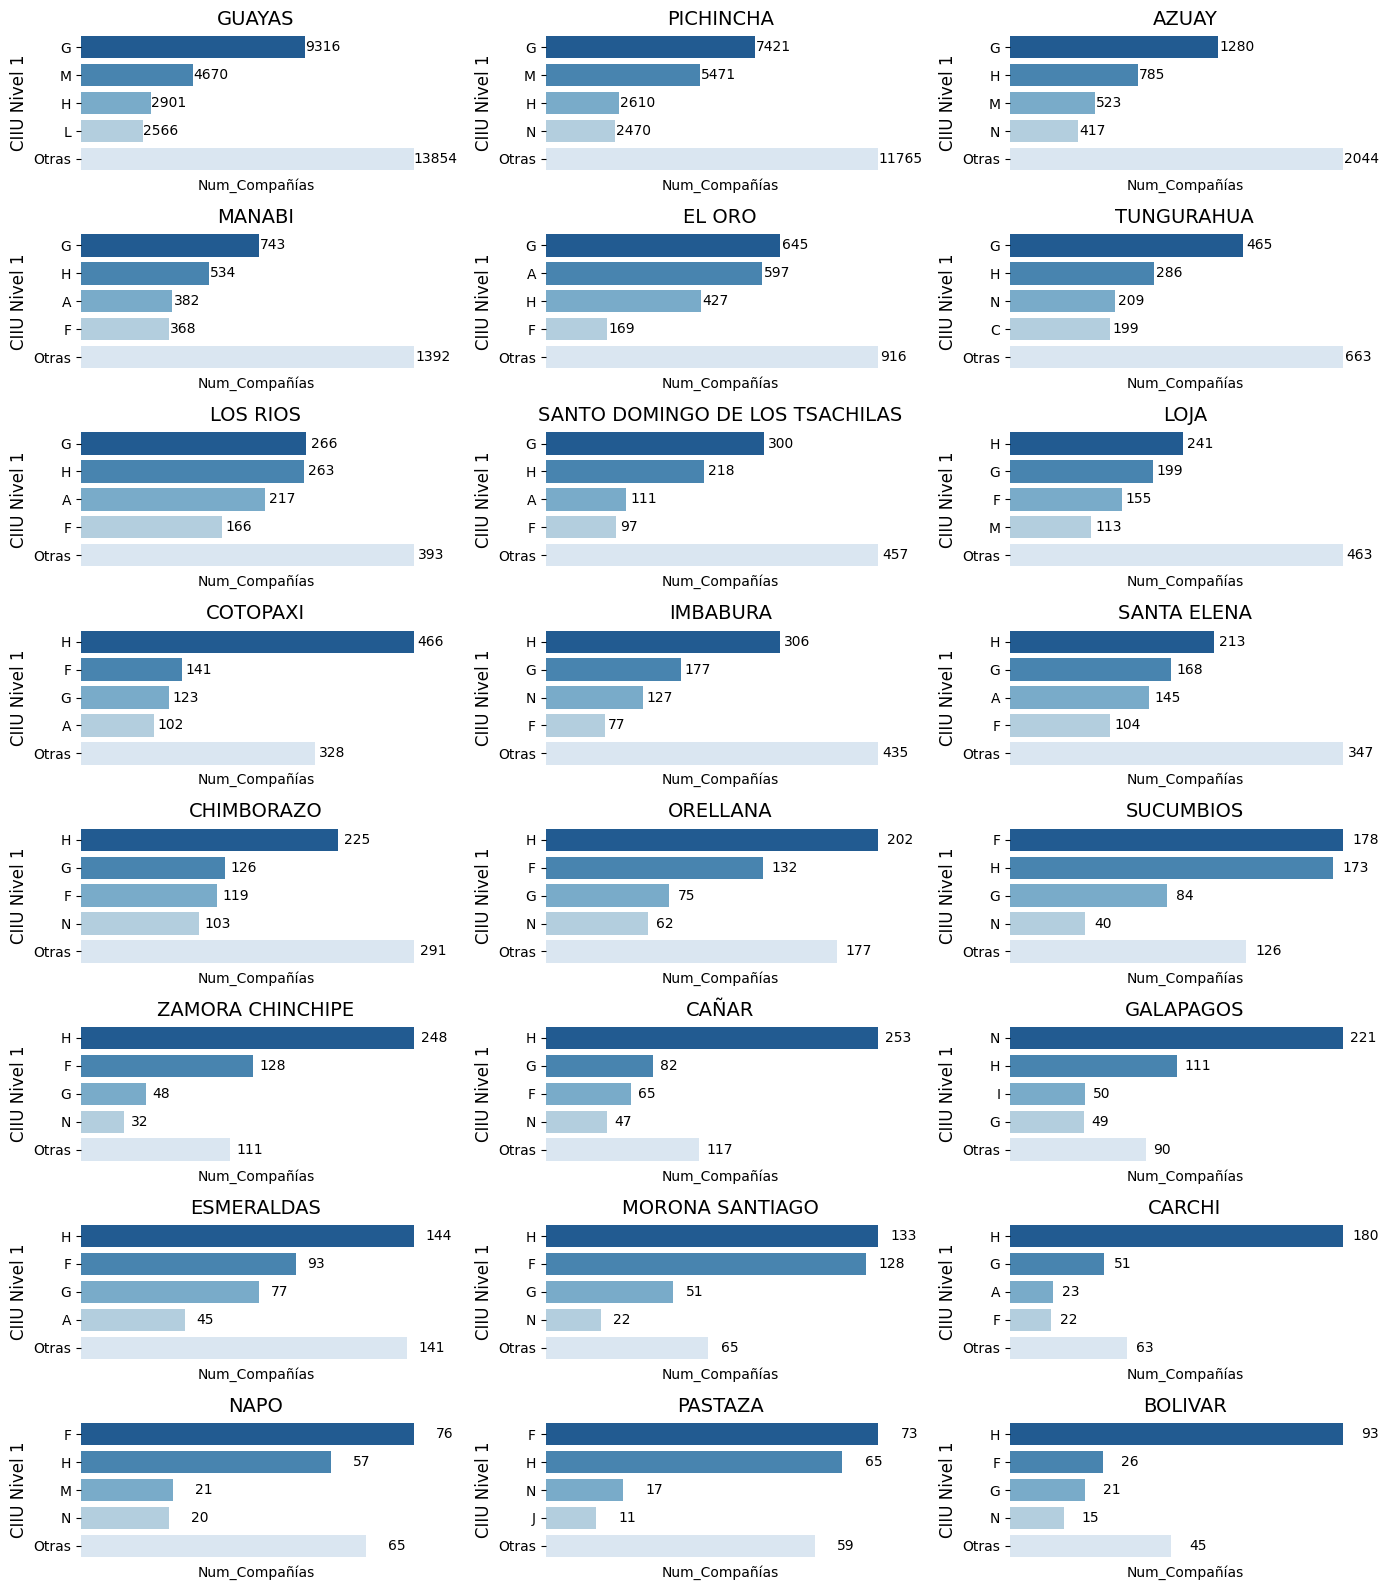

In [12]:
provincias = pd_companias['PROVINCIA'].value_counts().index

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(14, 16))
axes = axes.flatten()

for ax, provincia in zip(axes, provincias):

    top_tipo_empresa = agrupar_y_reducir_a_top_categories(pd_companias, group_col='TIPO', value_col='Num_Compañías', top_n=4)


    filtered_data = pd_companias[pd_companias['PROVINCIA'] == provincia]
    # company_counts = filtered_data['CIIU_NIVEL_1'].value_counts()
    

    company_counts = agrupar_y_reducir_a_top_categories(filtered_data, group_col='CIIU_NIVEL_1', value_col='Num_Compañías', top_n=4)
        
    sns.barplot(x=company_counts['Num_Compañías'], y=company_counts['CIIU_NIVEL_1'], ax=ax, palette="Blues_r", hue=company_counts['CIIU_NIVEL_1'])


    ax.set_title(f'{provincia}', fontsize=14)
    ax.set_ylabel('CIIU Nivel 1', fontsize=12)
    
    # Mostrar el número al final de cada barra sin que desborde
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 5, p.get_y() + p.get_height() / 2, f'{int(width)}', 
                va='center', fontsize=10, color='black')
         
    # Eliminar el recuadro negro
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Eliminar los ticks y etiquetas del eje X
    ax.set_xticks([])
    ax.set_xticklabels([])

# Eliminar ejes vacíos si hay menos provincias
for ax in axes[len(provincias):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Por **Region**

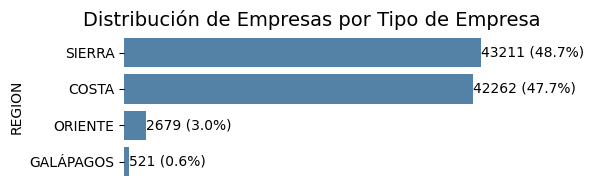

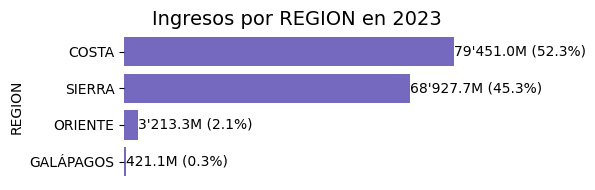

In [13]:
top_region = agrupar_y_reducir_a_top_categories(pd_companias, group_col='REGION', value_col='Num_Compañías', top_n=5)
presentar_grafico_barras(top_region, x_col='Num_Compañías', y_col='REGION', show_percentage=True, color='steelblue', figsize=(6, 2),
                         title='Distribución de Empresas por Tipo de Empresa')

# Reducir a top 4 categorías por suma de ingresos
top_ingresos_region = sumar_y_reducir_a_top_categories(pd_companias, group_col='REGION', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

# print(top_ingresos_segmentos)
presentar_grafico_barras(top_ingresos_region, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='REGION', show_percentage=True, color='slateblue', figsize=(6, 2),
                         title='Ingresos por REGION en 2023')

### Revisión por **CIIU**

Distribución de compañías en Ecuador por **CIIU NIVEL 1 SECTOR** y por **Ingresos**

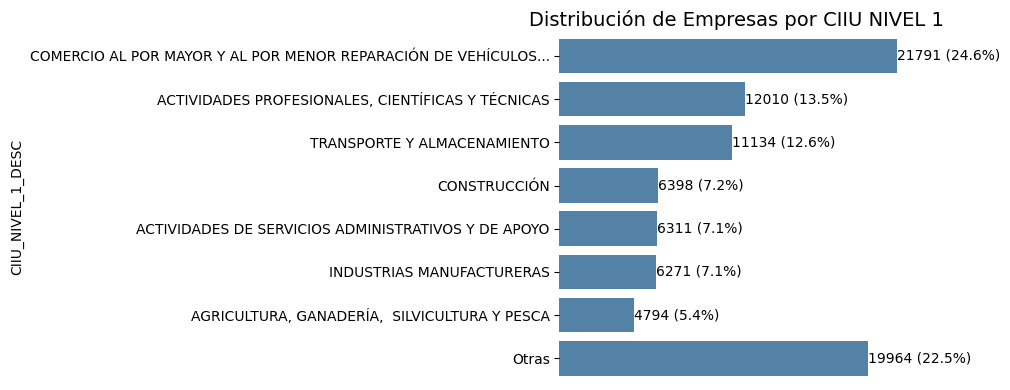

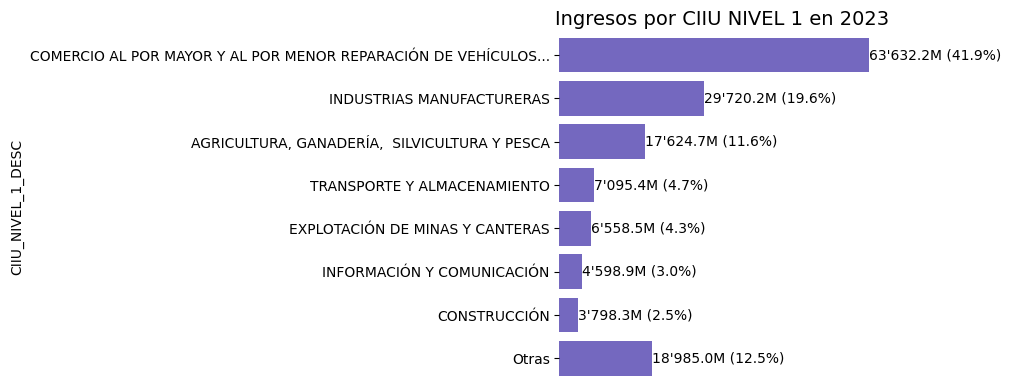

In [14]:
top_ciiu_nivel_1 = agrupar_y_reducir_a_top_categories(pd_companias, group_col='CIIU_NIVEL_1_DESC', value_col='Num_Compañías', top_n=7)
presentar_grafico_barras(top_ciiu_nivel_1, x_col='Num_Compañías', y_col='CIIU_NIVEL_1_DESC', show_percentage=True, color='steelblue', figsize=(10, 4),
                         title='Distribución de Empresas por CIIU NIVEL 1')

# Reducir a top 8 categorías por suma de ingresos
top_ingresos_ciiu_nivel_1 = sumar_y_reducir_a_top_categories(pd_companias, group_col='CIIU_NIVEL_1_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=7)

# print(top_ingresos_segmentos)
presentar_grafico_barras(top_ingresos_ciiu_nivel_1, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_1_DESC', show_percentage=True, color='slateblue', figsize=(10, 4),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

### Revisión por **CIIU NIVEL 4 - CLASE** 

A - Agricultura, ganadería, silvicultura y pesca

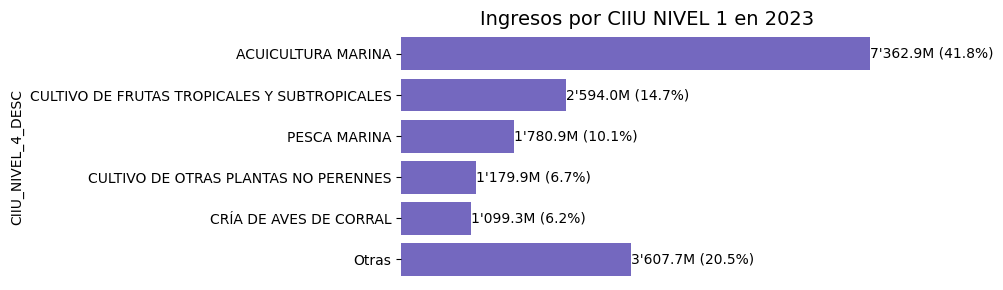

In [15]:
# Filtramos solo CIIU 1 A
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1']=='A']
# top_ciiu_nivel_1_A = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1_A, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1_A = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1_A, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 3),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

B - Explotación de minas y canteras

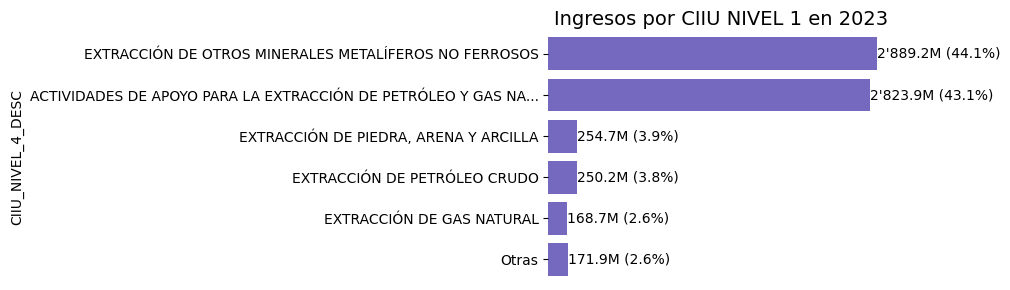

In [16]:
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1']=='B']

# top_ciiu_nivel_1_B = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1_B, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1_B = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1_B, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 3),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

C - Industrias manufactureras

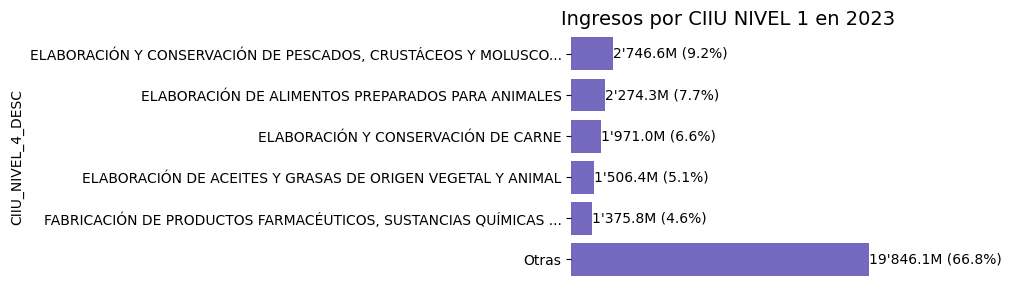

In [17]:
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1']=='C']

# top_ciiu_nivel_1_C = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1_C, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1_C = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1_C, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 3),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

G - Comercio

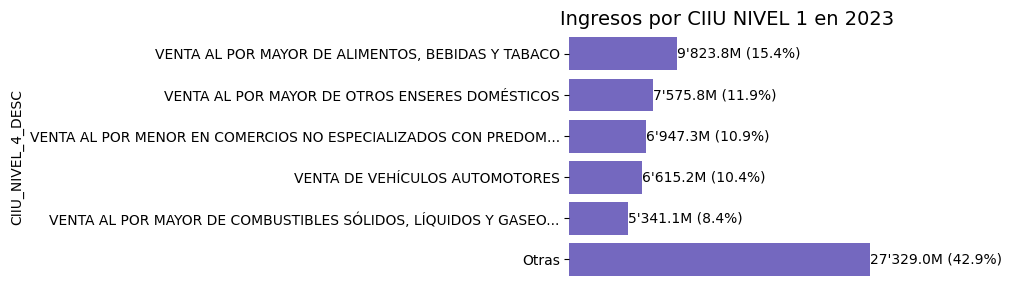

In [18]:
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1']=='G']

# top_ciiu_nivel_1 = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1 = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 3),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

F - Construcción Construcción

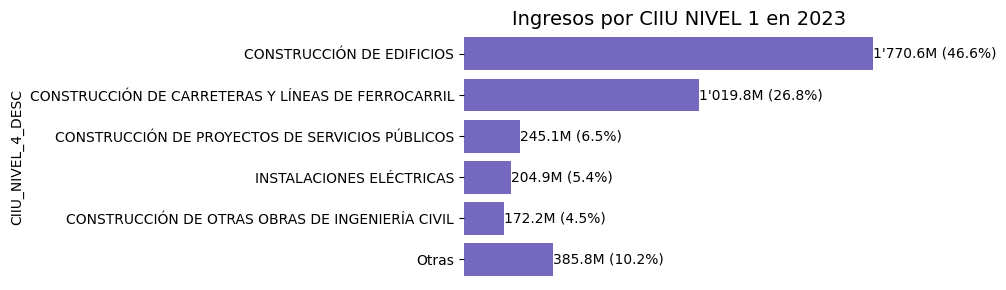

In [19]:
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1']=='F']

# top_ciiu_nivel_1 = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1 = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 3),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

SERVICIOS

J - Información y comunicación

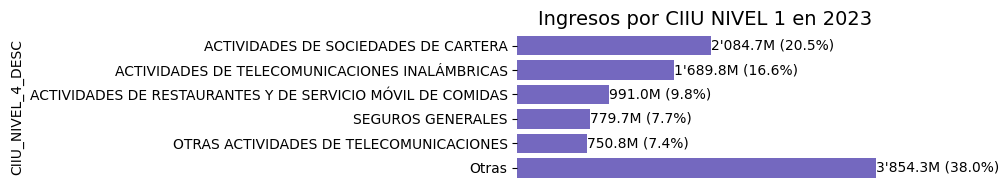

In [20]:
# pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1'].isin(['H','I','J','M','D'])]
pd_companias_agrucultura = pd_companias[pd_companias['CIIU_NIVEL_1'].isin(['I','J','K'])]


# top_ciiu_nivel_1 = agrupar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', value_col='Num_Compañías', top_n=5)

# presentar_grafico_barras(top_ciiu_nivel_1, x_col='Num_Compañías', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='steelblue', figsize=(10, 3),
#                          title='Distribución de Empresas por CIIU NIVEL 4')

# Top 5 categorías Agrupado por ingresos
top_ingresos_ciiu_nivel_1 = sumar_y_reducir_a_top_categories(pd_companias_agrucultura, group_col='CIIU_NIVEL_4_DESC', 
    value_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', top_n=5)

presentar_grafico_barras(top_ingresos_ciiu_nivel_1, x_col='INGRESOS_ACTIVIDADES_ORDINARIAS_2023', y_col='CIIU_NIVEL_4_DESC', show_percentage=True, color='slateblue', figsize=(10, 2),
                         title='Ingresos por CIIU NIVEL 1 en 2023')

## Tablas de resumen

### Resumen por CIIU Nivel 1 - SECCION

In [21]:
# Agrupar por CIIU_NIVEL_1 y CIIU_NIVEL_1_DESC para calcular totales
df_totales = pd_companias.groupby(['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC']).agg(
    NUMERO_EMPRESAS=('CIIU_NIVEL_1_DESC', 'size'),
    VENTAS=('INGRESOS_ACTIVIDADES_ORDINARIAS_2023', 'sum')
).reset_index()

# Calcular el número de empresas por segmento dentro de cada categoría
df_segmentos = pd_companias.groupby(['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC', 'SEGMENTO']).size().reset_index(name='COUNT')

# Calcular el porcentaje de empresas por segmento
df_segmentos_totales = df_segmentos.groupby(['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'])['COUNT'].transform('sum')
df_segmentos['PORCENTAJE'] = (df_segmentos['COUNT'] / df_segmentos_totales) * 100

# Pivotear los segmentos para crear columnas de porcentajes
df_pivot_segmentos = df_segmentos.pivot(
    index=['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'],
    columns='SEGMENTO',
    values='PORCENTAJE'
).reset_index()

# Renombrar columnas de segmentos para reflejar los porcentajes
df_pivot_segmentos.rename(columns={'GRANDE': '% GRANDES', 'MEDIANA': '% MEDIANA', 'PEQUENA': '% PEQUENA', 'MICRO': '% MICRO'}, inplace=True)

# Calcular el número de empresas por región dentro de cada categoría
df_regiones = pd_companias.groupby(['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC', 'REGION']).size().reset_index(name='COUNT')

# Calcular el porcentaje de empresas por región
df_regiones_totales = df_regiones.groupby(['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'])['COUNT'].transform('sum')
df_regiones['PORCENTAJE'] = (df_regiones['COUNT'] / df_regiones_totales) * 100

# Pivotear las regiones para crear columnas de porcentajes
df_pivot_regiones = df_regiones.pivot(
    index=['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'],
    columns='REGION',
    values='PORCENTAJE'
).reset_index()

# Renombrar columnas de regiones para reflejar los porcentajes
df_pivot_regiones.rename(columns={ 'SIERRA': '% SIERRA', 'COSTA': '% COSTA', 'ORIENTE': '% ORIENTE', 'GALÁPAGOS': '% GALÁPAGOS'}, inplace=True)

# Combinar los totales con los porcentajes de segmentos y regiones
df_final = pd.merge(df_totales, df_pivot_segmentos, on=['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'], how='left')
df_final = pd.merge(df_final, df_pivot_regiones, on=['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC'], how='left')

# Rellenar NaNs con 0 para las columnas de porcentajes
df_final.fillna(0, inplace=True)

# Formatear columnas con máximo 2 decimales y sin notación científica
pd.options.display.float_format = '{:.2f}'.format

# Ordenar las columnas del resultado final
df_final = df_final[['CIIU_NIVEL_1', 'CIIU_NIVEL_1_DESC', 'NUMERO_EMPRESAS', 'VENTAS',
                     '% GRANDES', '% MEDIANA', '% PEQUENA', '% MICRO',
                     '% SIERRA', '% COSTA', '% ORIENTE', '% GALÁPAGOS']]

# Mostrar el DataFrame final
df_final_sorted = df_final.sort_values(by="VENTAS", ascending=False).reset_index(drop=True)
# df_final_sorted.set_index("CIIU_NIVEL_1")
df_final_sorted

,CIIU_NIVEL_1,CIIU_NIVEL_1_DESC,NUMERO_EMPRESAS,VENTAS,% GRANDES,% MEDIANA,% PEQUENA,% MICRO,% SIERRA,% COSTA,% ORIENTE,% GALÁPAGOS
0,G,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,21791,63632154749.78,7.26,14.13,34.39,44.22,47.01,51.47,1.29,0.22
1,C,INDUSTRIAS MANUFACTURERAS,6271,29720247537.76,10.43,16.17,33.25,40.15,50.23,48.05,1.51,0.21
2,A,"AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA",4794,17624660859.63,10.62,20.03,31.54,37.82,25.55,73.28,0.96,0.21
3,H,TRANSPORTE Y ALMACENAMIENTO,11134,7095382136.27,1.62,8.50,35.04,54.85,50.86,40.26,7.89,1.00
4,B,EXPLOTACIÓN DE MINAS Y CANTERAS,720,6558498321.91,11.25,14.03,30.56,44.17,52.08,40.83,7.08,0.00
5,J,INFORMACIÓN Y COMUNICACIÓN,4233,4598898951.61,1.68,5.88,30.12,62.32,60.64,37.59,1.65,0.12
6,F,CONSTRUCCIÓN,6398,3798274464.65,1.83,7.08,30.17,60.93,42.67,45.90,11.18,0.25
7,K,ACTIVIDADES FINANCIERAS Y DE SEGUROS,1998,3769161231.22,5.26,12.36,34.93,47.45,55.61,43.99,0.40,0.00
8,M,"ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS",12010,3659034720.56,0.88,4.17,28.94,66.00,54.65,43.85,1.35,0.16
9,N,ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE ...,6311,3399558923.60,1.84,7.16,30.14,60.86,57.60,35.84,3.06,3.50


---

### Resumen por Provincia y CIIU Nivel 1 - SECCION

In [22]:
# Agrupar por CIIU_NIVEL_1 y CIIU_NIVEL_1_DESC para calcular totales
df_totales_provincias = pd_companias.groupby(['PROVINCIA', 'CIIU_NIVEL_1_DESC']).agg(
    NUMERO_EMPRESAS=('CIIU_NIVEL_1_DESC', 'size'),
    INGRESOS=('INGRESOS_ACTIVIDADES_ORDINARIAS_2023', 'sum')
).reset_index()
df_totales_provincias = df_totales_provincias.sort_values(by=['PROVINCIA', 'INGRESOS'], ascending=[True, False]).reset_index(drop=True)
# df_totales_provincias.head(15)

# Tomar los 3 primeros registros con mayores ingresos por cada provincia
df_top3_por_provincia = df_totales_provincias.groupby('PROVINCIA').head(3).reset_index(drop=True)

df_top3_por_provincia['INGRESOS'] = df_top3_por_provincia['INGRESOS'].apply(lambda x: f"${x:,.2f}")

# Mostrar el resultado
df_top3_por_provincia.head(50)

,PROVINCIA,CIIU_NIVEL_1_DESC,NUMERO_EMPRESAS,INGRESOS
0,AZUAY,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,1280,"$3,189,137,809.39"
1,AZUAY,INDUSTRIAS MANUFACTURERAS,356,"$1,796,799,691.96"
2,AZUAY,TRANSPORTE Y ALMACENAMIENTO,785,"$185,077,136.27"
3,BOLIVAR,TRANSPORTE Y ALMACENAMIENTO,93,"$15,600,173.41"
4,BOLIVAR,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,21,"$5,551,817.66"
5,BOLIVAR,ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y D...,3,"$3,617,660.53"
6,CARCHI,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,51,"$86,876,817.65"
7,CARCHI,TRANSPORTE Y ALMACENAMIENTO,180,"$68,754,930.73"
8,CARCHI,"AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA",23,"$23,711,372.02"
9,CAÑAR,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,82,"$172,817,204.97"


## Otras revisiones

C:\Users\fabrizio\AppData\Local\Temp\ipykernel_16968\3646988529.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=company_counts.values, y=company_counts.index, palette="Blues_r")


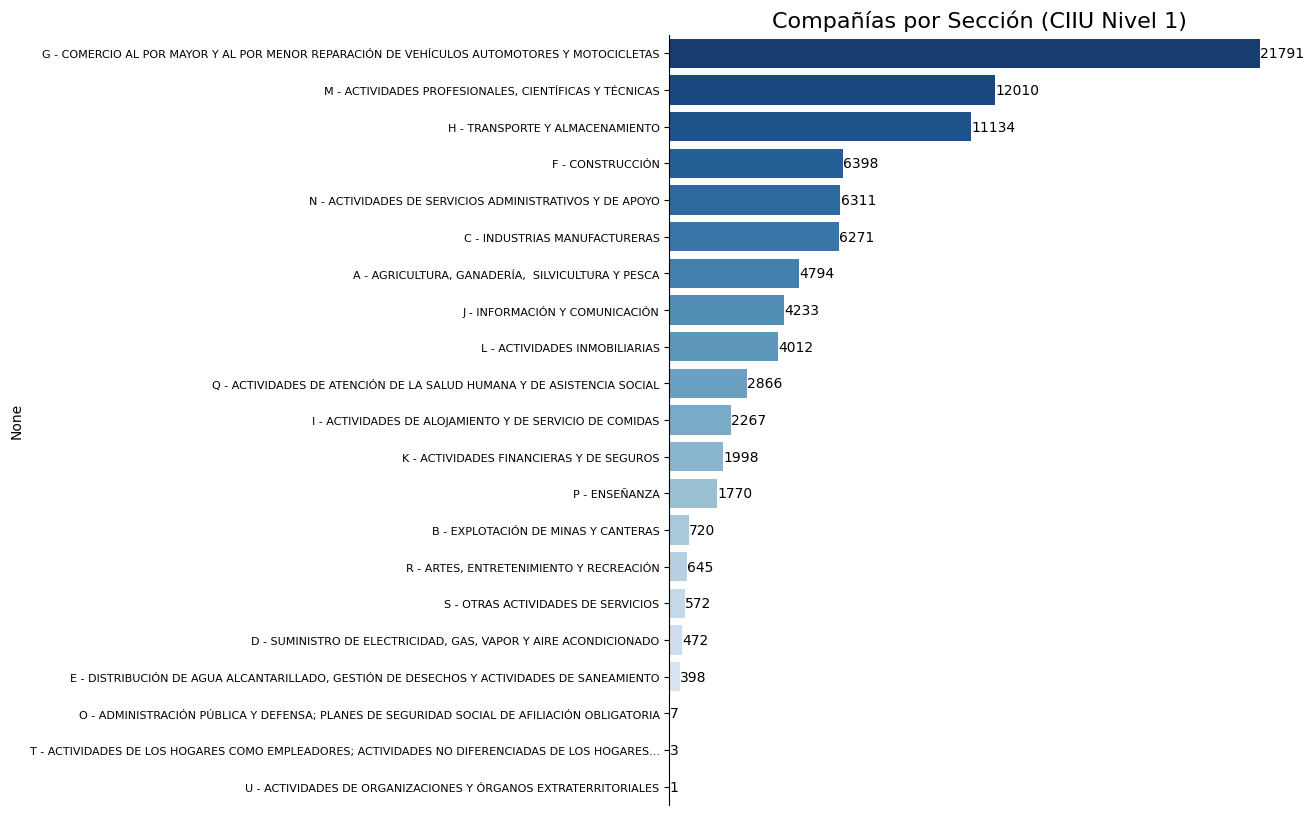

In [23]:
# # Dataset para gráfico y truncar las descripciones por si sonmuy grandes
company_counts = pd_companias['CIIU_NIVEL_1'].astype(str) + " - " + pd_companias['CIIU_NIVEL_1_DESC']
company_counts = company_counts.apply(lambda x: x[:92] + '...' if len(x) > 92 else x)
company_counts = company_counts.value_counts()
company_counts

# Dimensión del gráfico
plt.figure(figsize=(8, 10))

# Tipo de gráfico con barras más gruesas
sns.barplot(x=company_counts.values, y=company_counts.index, palette="Blues_r")

# Detalles Visuales al gráfico
plt.title('Compañías por Sección (CIIU Nivel 1)', fontsize=16)
plt.xticks([])  # Elimina los ticks del eje X
plt.yticks(fontsize=8)  # Reduce el tamaño de las etiquetas en el eje Y

# Eliminar la línea del eje X
plt.gca().spines['bottom'].set_linewidth(0)

# Elimina bordes del gráfico
sns.despine()

# Mostrar el número al final de cada barra
for p in plt.gca().patches:
    plt.gca().text(p.get_width() + 10, p.get_y() + p.get_height() / 2, 
                   f'{int(p.get_width())}', va='center', fontsize=10, color='black')

# Mostrar el gráfico
plt.show()

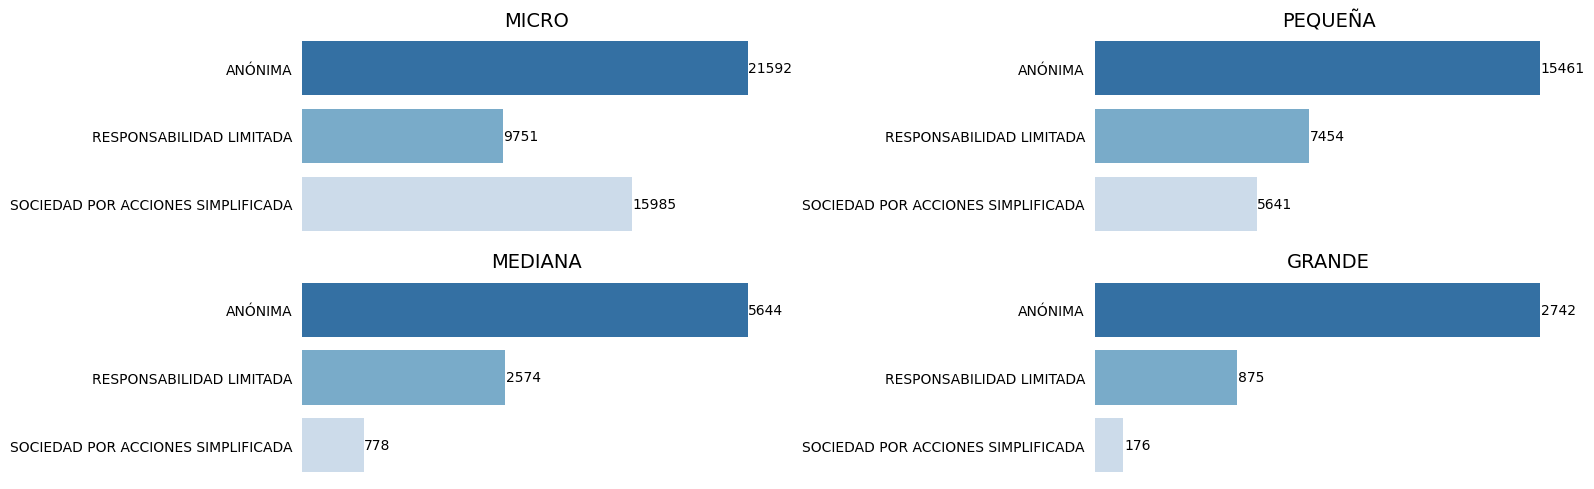

In [24]:
# Filtrar datos por cada segmento
segmento_micro = pd_companias[pd_companias['SEGMENTO'] == 'MICRO']
segmento_pequena = pd_companias[pd_companias['SEGMENTO'] == 'PEQUENA']
segmento_mediana = pd_companias[pd_companias['SEGMENTO'] == 'MEDIANA']
segmento_grande = pd_companias[pd_companias['SEGMENTO'] == 'GRANDE']

# Agrupar datos por tipo para cada segmento
micro_counts = segmento_micro.groupby('TIPO').size().reset_index(name='Num_Compañías')
pequena_counts = segmento_pequena.groupby('TIPO').size().reset_index(name='Num_Compañías')
mediana_counts = segmento_mediana.groupby('TIPO').size().reset_index(name='Num_Compañías')
grande_counts = segmento_grande.groupby('TIPO').size().reset_index(name='Num_Compañías')

# Paleta de colores personalizada
custom_palette = ['#1f77b4', '#2ca02c', '#6a0dad']  # Azul, Verde, Dorado

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 5))  # Configurar figura con subplots 2x2

# Función para agregar números al final de las barras
def add_numbers_at_end(ax):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 5, p.get_y() + p.get_height() / 2., f'{int(width)}', 
                ha='left', va='center', fontsize=10)

# Gráfico 1: MICRO
sns.barplot(y='TIPO', x='Num_Compañías', data=micro_counts, ax=axes[0, 0], palette='Blues_r', hue='TIPO', legend=False)
axes[0, 0].set_title('MICRO', fontsize=14)
axes[0, 0].set_xlabel('', fontsize=12)
axes[0, 0].set_ylabel('', fontsize=12)
axes[0, 0].set_xticks([])  # Eliminar números del eje X
axes[0, 0].tick_params(axis='y', left=False)
for spine in axes[0, 0].spines.values():
    spine.set_visible(False)
add_numbers_at_end(axes[0, 0])

# Gráfico 2: PEQUEÑA
sns.barplot(y='TIPO', x='Num_Compañías', data=pequena_counts, ax=axes[0, 1], palette='Blues_r', hue='TIPO', legend=False)
axes[0, 1].set_title('PEQUEÑA', fontsize=14)
axes[0, 1].set_xlabel('', fontsize=12)
axes[0, 1].set_ylabel('', fontsize=12)
axes[0, 1].set_xticks([])  # Eliminar números del eje X
axes[0, 1].tick_params(axis='y', left=False)
for spine in axes[0, 1].spines.values():
    spine.set_visible(False)
add_numbers_at_end(axes[0, 1])

# Gráfico 3: MEDIANA
sns.barplot(y='TIPO', x='Num_Compañías', data=mediana_counts, ax=axes[1, 0], palette='Blues_r', hue='TIPO', legend=False)
axes[1, 0].set_title('MEDIANA', fontsize=14)
axes[1, 0].set_xlabel('', fontsize=12)
axes[1, 0].set_ylabel('', fontsize=12)
axes[1, 0].set_xticks([])  # Eliminar números del eje X
axes[1, 0].tick_params(axis='y', left=False)
for spine in axes[1, 0].spines.values():
    spine.set_visible(False)
add_numbers_at_end(axes[1, 0])

# Gráfico 4: GRANDE
sns.barplot(y='TIPO', x='Num_Compañías', data=grande_counts, ax=axes[1, 1], palette='Blues_r', hue='TIPO', legend=False)
axes[1, 1].set_title('GRANDE', fontsize=14)
axes[1, 1].set_xlabel('', fontsize=12)
axes[1, 1].set_ylabel('', fontsize=12)
axes[1, 1].set_xticks([])  # Eliminar números del eje X
axes[1, 1].tick_params(axis='y', left=False)
for spine in axes[1, 1].spines.values():
    spine.set_visible(False)
add_numbers_at_end(axes[1, 1])

# Ajustar diseño
fig.tight_layout()
plt.show()


Adaptación de un gráfico del REEM (informe publicado por el INEC)

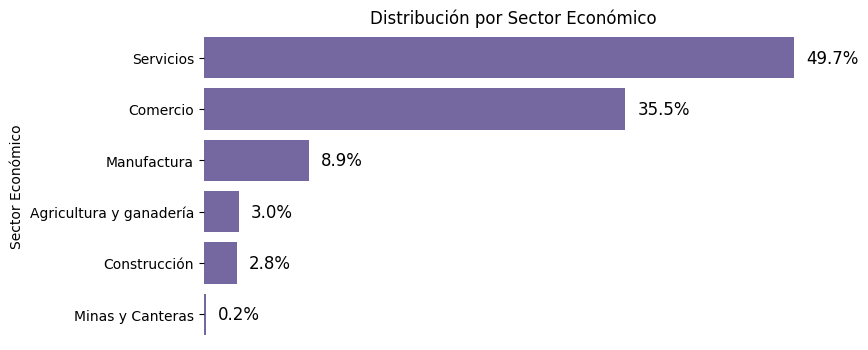

In [25]:
# Datos extraídos del gráfico de pastel
sectores = ["Servicios", "Comercio", "Manufactura", "Agricultura y ganadería", "Construcción", "Minas y Canteras"]
porcentajes = [49.7, 35.5, 8.9, 3.0, 2.8, 0.2]

# Crear DataFrame
df = pd.DataFrame({"Sector Económico": sectores, "Porcentaje": porcentajes})

# Configurar el gráfico de barras
plt.figure(figsize=(8, 4))

# Color uniforme (puedes cambiarlo a cualquier color de la paleta Seaborn o un código hexadecimal)
sns.barplot(x="Porcentaje", y="Sector Económico", data=df, color=sns.color_palette("Purples")[4], orient="h")

# Etiquetas y título
plt.xlabel("Porcentaje")
plt.ylabel("Sector Económico")
plt.title("Distribución por Sector Económico")
plt.gca().xaxis.set_visible(False)


# Mostrar los valores en cada barra
for index, value in enumerate(porcentajes):
    plt.text(value + 1, index, f"{value}%", va="center", fontsize=12)


# plt.gca().spines['top'].set_visible(False)
# Quitar los bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Mostrar gráfico
plt.show()